# Examples of using MultiTypeDBFE

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import dbfe

In [2]:
pos_class = "RES"

stat_vals = pd.read_csv(f"../experiments/data/ovarian/ovarian_cnv.csv.gz", index_col='SAMPLEID')
stat_vals = dbfe.MultiTypeDBFE.stack(stat_vals)

labels = pd.read_csv(f"../experiments/data/ovarian/labels.tsv", sep='\t', index_col=0)
labels = (labels == pos_class) * 1 # NONRES == 0, RES == 1
stat_df = stat_vals.join(labels.CLASS_LABEL, how='inner')

stat_df

,DEL,DIP,DUP,CLASS_LABEL
AOCS-001-1,"[15042483, 331439, 3964684, 164592, 209090, 13...","[30946073, 6972509, 221616, 15099673, 56047992...","[2972633, 19645951, 9414542, 2, 49685, 1749387...",0
AOCS-004-1,"[43470, 50089, 4621, 447396, 44482, 13584, 205...","[221563, 16778, 18106, 927179, 34529306, 16426...","[14439595, 57795746, 49007213, 863646, 11343, ...",0
AOCS-005-1,"[528900, 69282, 141248, 926831, 2508859, 50596...","[342237, 287003, 31802882, 319871, 17403809, 3...","[11803375, 341996, 247853, 27430, 77193, 17579...",0
AOCS-034-1,"[516668, 99479, 2455919, 12415179, 6877711, 38...","[86379, 19191251, 41294842, 22827188, 14953429...","[729166, 3647233, 33685984, 6803579, 48964, 32...",1
AOCS-055-1,"[503343, 105211, 237909, 297935, 54542, 275263...","[69067, 114971, 247533, 1095883, 13259528, 347...","[1203081, 1565337, 3127352, 15686053, 643348, ...",0
...,...,...,...,...
TCGA-36-1570,"[37248, 198462, 11435934, 21717737, 7998166, 1...","[76719248, 64665329, 35278088, 3529203, 383958...","[7903273, 798619, 1332253, 21404042, 72966, 10...",1
TCGA-36-1571,"[44211, 335207, 315813, 2516724, 631985, 15648...","[394319, 247404, 36703, 15994903, 29418394, 23...","[814153, 15955440, 91631, 8322778, 40846, 5457...",1
TCGA-36-1574,"[26054, 10585377, 47714, 1990, 356342, 4932892...","[16803720, 283856, 3321260, 22405041, 5635980,...","[230970, 16251, 3962415, 31126264, 104694, 2, ...",1
TCGA-61-2000,"[122287, 512304, 78553, 77328, 48860, 115082, ...","[5346245, 195933, 2357541, 43184057, 2990179, ...","[715045, 5184036, 2817815, 18009790, 611667, 6...",0


In [3]:
X = stat_df.drop("CLASS_LABEL", axis=1)
y = stat_df.loc[:, "CLASS_LABEL"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=23, stratify=y)

## Basic usage

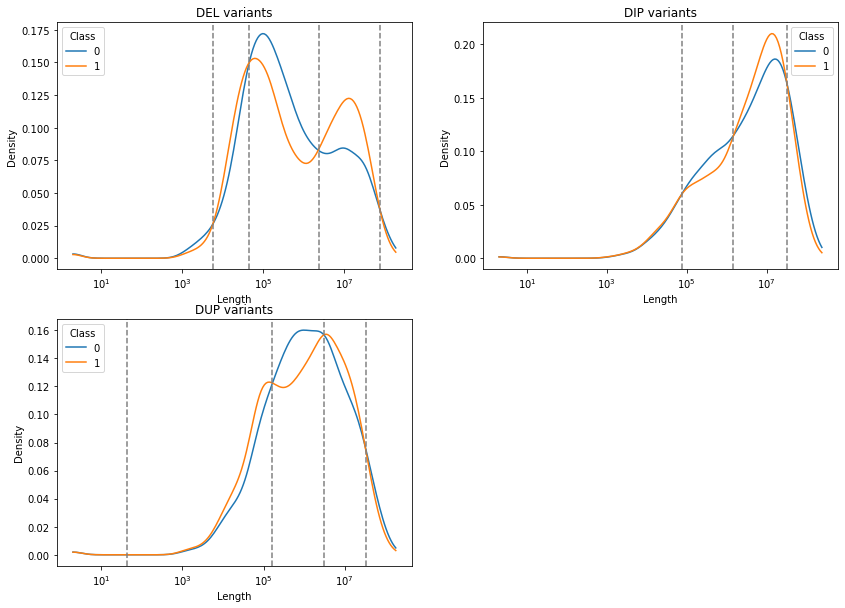

AUC on test data: 0.692


In [4]:
multi_extractor = dbfe.MultiTypeDBFE(breakpoint_type='supervised', n_bins='auto')
pipe = make_pipeline(multi_extractor, StandardScaler(), LogisticRegression())
pipe.fit(X_train, y_train)

plt.rcParams['figure.figsize'] = [14, 10]
multi_extractor.plot_data_with_breaks(X_train, y_train, plot_type='kde');

y_prob = pipe.predict_proba(X_test)
print("AUC on test data: {:.3}".format(roc_auc_score(y_test, y_prob[:, 1])))

## More complicated example

In [5]:
#this parameter can be used to perform DBFE only on selected columns
dbfe_cols = ['DUP', 'DEL', 'DIP']

custom_dbfe_args = {
    'DUP': dict(
        breakpoint_type='supervised',
        n_bins='auto'
    ),
    'DEL': dict(
        breakpoint_type='quantile',
        n_bins=10, 
    ),
    'DIP': dict(
        bins = [(0, 40000), (40000, 1000000), (1000000, np.inf)]
    )
}

tmp_extractor = dbfe.MultiTypeDBFE(dbfe_cols=dbfe_cols, custom_dbfe_args=custom_dbfe_args)
tmp_extractor.fit_transform(X_train, y_train)

,DEL_dbfe_0_22450,DEL_dbfe_22450_45938,DEL_dbfe_45938_84259,DEL_dbfe_84259_154000,DEL_dbfe_154000_330412,DEL_dbfe_330412_920505,DEL_dbfe_920505_3256626,DEL_dbfe_3256626_9241175,DEL_dbfe_9241175_23223309,DEL_dbfe_23223309_inf,...,DUP_dbfe_44_158429,DUP_dbfe_158429_3015793,DUP_dbfe_3015793_33040760,DUP_dbfe_33040760_inf,DUP_total_dbfe,DUP_frac_dbfe_0_44,DUP_frac_dbfe_44_158429,DUP_frac_dbfe_158429_3015793,DUP_frac_dbfe_3015793_33040760,DUP_frac_dbfe_33040760_inf
TCGA-25-1634,5,1,4,4,0,0,1,1,0,2,...,89,138,104,17,351,0.008547,0.253561,0.393162,0.296296,0.048433
HMF003013A,0,2,2,2,8,3,2,2,0,2,...,33,89,62,20,204,0.000000,0.161765,0.436275,0.303922,0.098039
TCGA-04-1514,12,6,9,5,1,6,3,3,2,1,...,37,79,39,16,172,0.005814,0.215116,0.459302,0.226744,0.093023
HMF003031A,1,2,2,3,3,3,5,2,2,1,...,68,296,151,16,531,0.000000,0.128060,0.557439,0.284369,0.030132
HMF002439A,4,9,7,10,26,30,17,2,0,0,...,85,123,23,0,232,0.004310,0.366379,0.530172,0.099138,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HMF001136A,9,4,3,4,1,3,1,1,0,0,...,63,225,146,15,449,0.000000,0.140312,0.501114,0.325167,0.033408
HMF003205A,8,7,13,6,10,6,9,16,8,6,...,88,126,110,6,331,0.003021,0.265861,0.380665,0.332326,0.018127
HMF000280A,2,2,2,2,3,2,3,3,5,7,...,10,6,1,6,23,0.000000,0.434783,0.260870,0.043478,0.260870
AOCS-139-4,16,4,10,5,21,12,14,2,0,3,...,30,97,154,5,287,0.003484,0.104530,0.337979,0.536585,0.017422


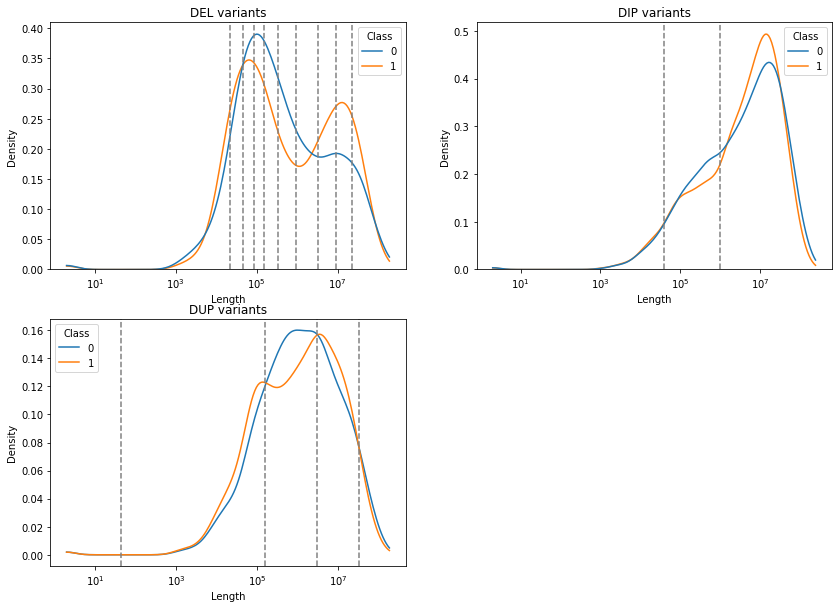

AUC on test data: 0.657


In [6]:
extractor = dbfe.MultiTypeDBFE(dbfe_cols=dbfe_cols, custom_dbfe_args=custom_dbfe_args)
pipe = make_pipeline(extractor, StandardScaler(), RandomForestClassifier(random_state=23))
pipe.fit(X_train, y_train)

plt.rcParams['figure.figsize'] = [14, 10]
extractor.plot_data_with_breaks(X_train, y_train, plot_type='kde');

y_prob = pipe.predict_proba(X_test)
print("AUC on test data: {:.3}".format(roc_auc_score(y_test, y_prob[:, 1])))